In [62]:
#!pip install matplotlib
#!pip install seaborn
#!pip install sklearn
#!pip install torch
#!pip install imblearn

In [63]:
import glob
import math
import os
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import scipy
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

In [64]:
import torch
from torch import nn
from torch import optim


In [65]:
torch.__version__

'1.12.1+cpu'

## Load the dataset

In [66]:
data = pd.read_excel('data.xlsx')

In [67]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   File         1750 non-null   object
 1   PeStructure  1750 non-null   object
 2   Class        1750 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 41.1+ KB
None


In [68]:
data['PeStructure'] = data['PeStructure'].astype("string")

In [69]:
# in_progress status was removed
data["Class"].unique()

array([0, 1], dtype=int64)

<AxesSubplot: xlabel='Class', ylabel='count'>

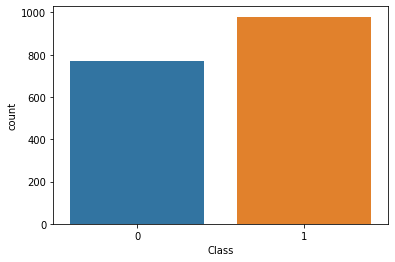

In [70]:
# Check the balance
sns.countplot(x = 'Class', data = data)

In [71]:
# Upsample minority class
data = pd.concat([data, data[data['Class'] == 0][:200]])

<AxesSubplot: xlabel='Class', ylabel='count'>

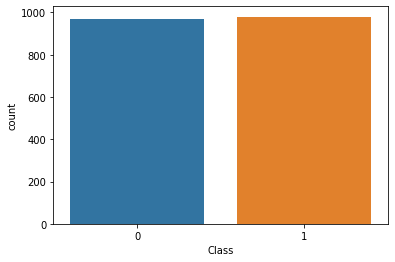

In [72]:
# Check the balance
sns.countplot(x = 'Class', data = data)

In [73]:
data["PeStructure"][:5]

0    DIRECTORY_ENTRY_BASERELOC DIRECTORY_ENTRY_DEBU...
1    DIRECTORY_ENTRY_BASERELOC DIRECTORY_ENTRY_DEBU...
2    DIRECTORY_ENTRY_BASERELOC DIRECTORY_ENTRY_DEBU...
3    DIRECTORY_ENTRY_BASERELOC DIRECTORY_ENTRY_DEBU...
4    DIRECTORY_ENTRY_BASERELOC DIRECTORY_ENTRY_DEBU...
Name: PeStructure, dtype: string

In [74]:
# Show any missing text
data[pd.isnull(data['PeStructure'])]

,File,PeStructure,Class


In [75]:
# Check if dataset is balanced
counts = data["Class"].value_counts()
counts

1    980
0    970
Name: Class, dtype: int64

In [76]:
# Shuffle rows in the dataframe
data = data.sample(frac=1)

# Train test split

In [77]:
x_train, x_test, y_train, y_test = train_test_split(data["PeStructure"], data["Class"], test_size=.2, random_state=7)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1560,) (390,) (1560,) (390,)


# Prepare the tokenizer

In [78]:
vectorizer = TfidfVectorizer()

In [79]:
# Learn vocabulary from the training data and vectorize in one go.
x_train = vectorizer.fit_transform(x_train)

# Vectorize the test data.
x_test = vectorizer.transform(x_test)

In [80]:
# Lets look at the vocabulary
vectorizer.get_feature_names_out()

array(['0_dll', '10_dll', '18', '19', '1_0', '1_1_dll', '1_dll', '20_dll',
       '2_0', '2_0_dll', '2_dll', '30_dll', '3_dll', '4_dll', '5_dll',
       '6_dll', '7_dll', '8_dll', '9_dll', '__class__', '__data__',
       '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__',
       '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__',
       '__gt__', '__hash__', '__image_base_relocation_entry_format__',
       '__image_base_relocation_format__',
       '__image_bound_forwarder_ref_format__',
       '__image_bound_import_descriptor_format__',
       '__image_data_directory_format__',
       '__image_debug_directory_format__',
       '__image_delay_import_descriptor_format__',
       '__image_dos_header_format__', '__image_export_directory_format__',
       '__image_file_header_format__',
       '__image_import_descriptor_format__',
       '__image_load_config_directory64_format__',
       '__image_load_config_directory_format__',
       '__image_nt_headers_format__',

In [81]:
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(x_train)).float()
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(x_test)).float()

In [82]:
x_train.shape[1]

823

In [83]:
x_test.shape[1]

823

In [84]:
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

# Define NN architecture
  
Inspired by: https://medium.com/swlh/text-classification-using-scikit-learn-pytorch-and-tensorflow-a3350808f9f7

In [85]:
model = nn.Sequential(nn.Linear(x_train.shape[1], 64),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(64, data['Class'].nunique()),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Forward pass, get our logits
logps = model(x_train)

# Calculate the loss with the logits and the labels
loss = criterion(logps, y_train)

loss.backward()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [86]:
print(model)

Sequential(
  (0): Linear(in_features=823, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=64, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


# Model training

In [87]:
%%time
train_losses = []
test_losses = []
test_accuracies = []

epochs = 100
for e in range(epochs):
    optimizer.zero_grad()

    output = model.forward(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    optimizer.step()

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        log_ps = model(x_test)
        test_loss = criterion(log_ps, y_test)
        test_losses.append(test_loss)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y_test.view(*top_class.shape)
        test_accuracy = torch.mean(equals.float())
        test_accuracies.append(test_accuracy)

    model.train()

    print(f"Epoch: {e+1}/{epochs}.. ",
          f"Training Loss: {train_loss:.3f}.. ",
          f"Test Loss: {test_loss:.3f}.. ",
          f"Test Accuracy: {test_accuracy:.3f}")

Epoch: 1/100..  Training Loss: 0.697..  Test Loss: 0.689..  Test Accuracy: 0.490
Epoch: 2/100..  Training Loss: 0.687..  Test Loss: 0.682..  Test Accuracy: 0.490
Epoch: 3/100..  Training Loss: 0.679..  Test Loss: 0.675..  Test Accuracy: 0.733
Epoch: 4/100..  Training Loss: 0.671..  Test Loss: 0.668..  Test Accuracy: 0.703
Epoch: 5/100..  Training Loss: 0.663..  Test Loss: 0.661..  Test Accuracy: 0.682
Epoch: 6/100..  Training Loss: 0.655..  Test Loss: 0.655..  Test Accuracy: 0.679
Epoch: 7/100..  Training Loss: 0.648..  Test Loss: 0.649..  Test Accuracy: 0.674
Epoch: 8/100..  Training Loss: 0.640..  Test Loss: 0.643..  Test Accuracy: 0.672
Epoch: 9/100..  Training Loss: 0.634..  Test Loss: 0.638..  Test Accuracy: 0.672
Epoch: 10/100..  Training Loss: 0.628..  Test Loss: 0.633..  Test Accuracy: 0.674
Epoch: 11/100..  Training Loss: 0.621..  Test Loss: 0.628..  Test Accuracy: 0.674
Epoch: 12/100..  Training Loss: 0.616..  Test Loss: 0.624..  Test Accuracy: 0.677
Epoch: 13/100..  Training

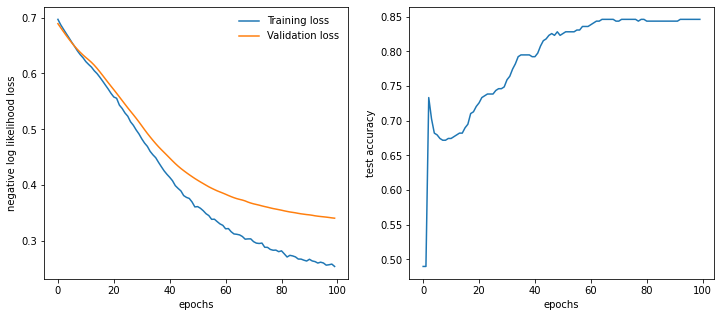

In [88]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('negative log likelihood loss')
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False);
plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.plot(test_accuracies);

# Metrics

In [89]:
y_test_pred = model(x_test)

In [90]:
y_test_pred[:5]

tensor([[-6.7345e-02, -2.7314e+00],
        [-2.3790e+00, -9.7217e-02],
        [-9.3873e-03, -4.6731e+00],
        [-4.0998e-03, -5.4989e+00],
        [-5.4222e-03, -5.2200e+00]], grad_fn=<SliceBackward0>)

In [91]:
# get predictions from the tensor
pred = y_test_pred.max(1).indices

In [92]:
pred

tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,

In [93]:
y_test

tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,

In [94]:
# Number of false positives
np.count_nonzero( np.greater(pred.cpu().detach().numpy(), y_test.cpu().detach().numpy()) )

42

In [95]:
# Number of false negatives
np.count_nonzero( np.greater(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy()) )

14

In [96]:
conf_mat = confusion_matrix(y_true = y_test, y_pred = pred)
conf_mat

array([[149,  42],
       [ 14, 185]], dtype=int64)

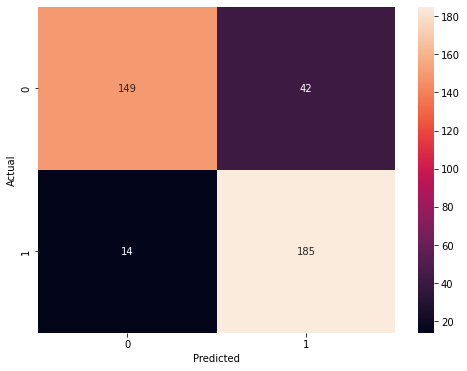

In [97]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d"
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

Note - high false positive amount indicates that more work needs to be done in the field of feature extraction.

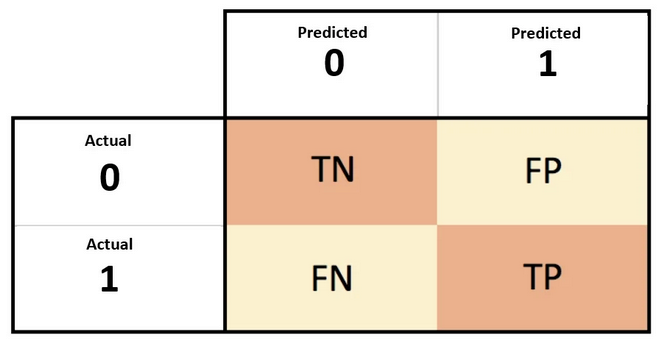

In [98]:
print(classification_report(y_true = y_test, y_pred = pred))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       191
           1       0.81      0.93      0.87       199

    accuracy                           0.86       390
   macro avg       0.86      0.85      0.86       390
weighted avg       0.86      0.86      0.86       390



In [ ]:
# Precision – What percent of the predictions were correct?      Precision = TP / (TP + FP)
# Recall – What percent of the positive cases did you catch?     Recall = TP / (TP + FN))
# F1 score – What percent of positive predictions were correct?  F1 Score = 2*(Recall * Precision) / (Recall + Precision)
# Support - is the number of occurence of the given class in the dataset. Shows imbalance in the dataset.